# Comparación entre diferentes transformaciones del histograma

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

In [3]:
imagen_bougies = cv2.imread('images/BOUGIES.png', cv2.IMREAD_GRAYSCALE)

In [4]:
def mostrar_histograma(imagen):
    hist = cv2.calcHist([imagen],[0],None,[256],[0,256])
    plt.plot(hist)
    plt.show()

## Imagen (Original)

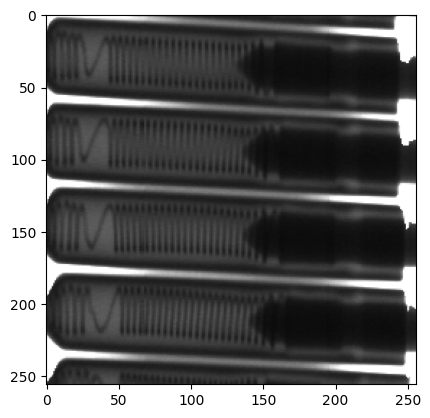

In [73]:
plt.imshow(imagen_bougies, cmap='gray', vmin=0, vmax=255)
plt.show()

## Histograma Imagen (Original)

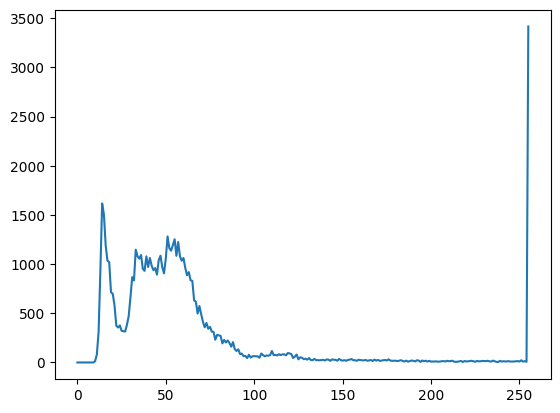

In [74]:
mostrar_histograma(imagen_bougies)

## Expansión del histograma

In [7]:
min_val, max_val, _, _ = cv2.minMaxLoc(imagen_bougies)

min_val, max_val = int(min_val), int(max_val)


In [8]:
def get_ab(li, ls):
    b = ((255 * li)/(li - ls))
    a = (255/(ls - li))
    return a,b

a,b = get_ab(min_val, max_val)

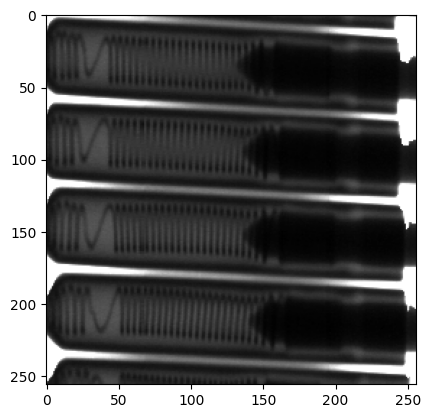

In [9]:
expansion = cv2.convertScaleAbs(imagen_bougies, alpha=a, beta=b)
plt.imshow(expansion, cmap='gray', vmin=0, vmax=255)
plt.show()

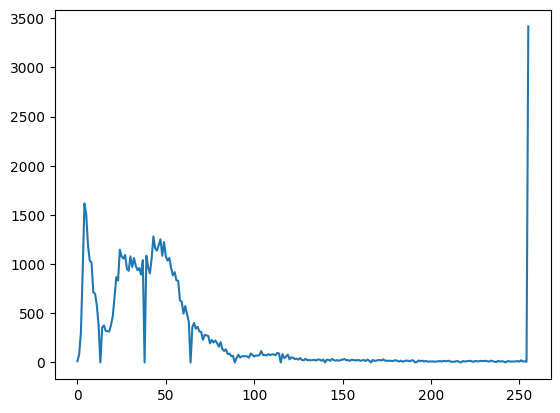

In [10]:
mostrar_histograma(expansion)

### *¿A qué se debe este resultado?*

El resultado se debe a la redistribución de los valores de intensidad, lo que mejoró el contraste, especialmente en las áreas oscuras. Sin embargo, debido a la predominancia de tonos oscuros, el histograma conservó su forma general, aunque con una distribución más equilibrada.

## Ecualización del histograma

In [11]:
imagen_equ = cv2.equalizeHist(imagen_bougies)

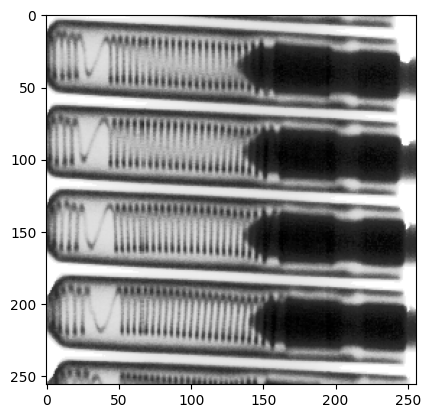

In [12]:
plt.imshow(imagen_equ, cmap='gray', vmin=0, vmax=255)
plt.show()

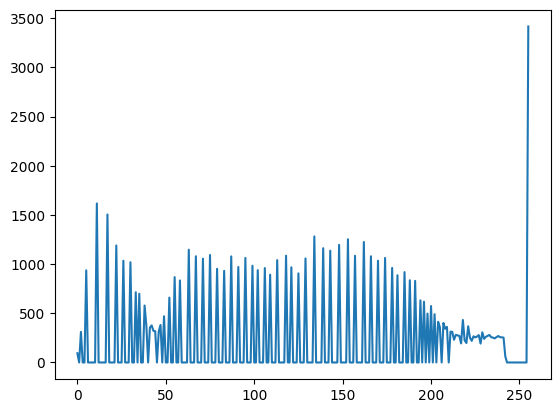

In [13]:
mostrar_histograma(imagen_equ)

### *Comente sus observaciones*

Al ecualizar la imagen, se obtuvo una mejor distribución de las intensidades en el histograma en comparación con la original, lo que mejoró el contraste y la definición. A diferencia de la imagen original, donde las intensidades estaban concentradas en los tonos oscuros, la ecualización permitió una redistribución más equilibrada.

## Transformación logarítmica 

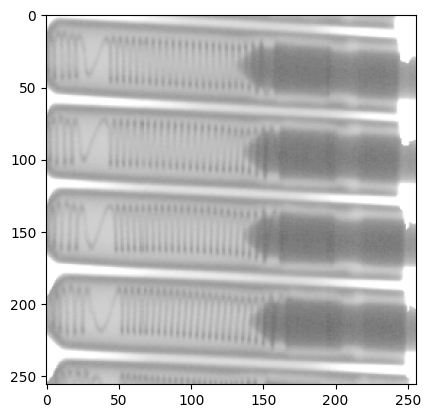

In [27]:
constant_value = 46
logaritmitc_transformation =  np.log1p(imagen_bougies.astype(np.float32))
multiplication = constant_value * logaritmitc_transformation

plt.imshow(multiplication, cmap='gray', vmin=0, vmax=255)
plt.show()

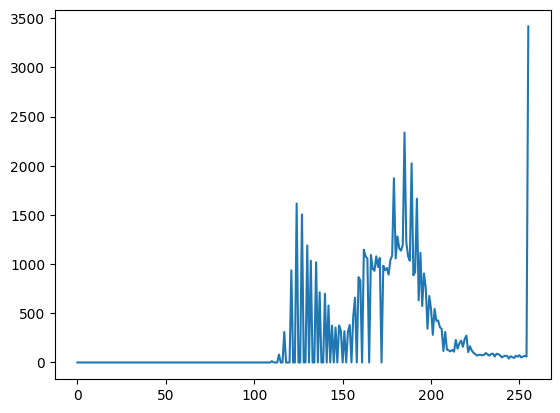

In [25]:
mostrar_histograma(multiplication)

### *¿Por qué es necesario multiplicar la imagen de salida por un factor? Visualice la imagen resultado y su histograma. ¿Cómo es el histograma resultado?*

La transformación logarítmica expande los píxeles oscuros y comprime los brillantes, reduciendo el rango dinámico y oscureciendo la imagen. La multiplicación por un factor reescala las intensidades lo que permite recuperar el brillo. En el histograma, esto se reflejado en una mayor concentración de valores en las altas intensidades, ya que los píxeles oscuros aumentan su brillo.

## Especificación de histogramas

In [14]:
histograma_original = cv2.calcHist([imagen_bougies],[0],None,[256],[0,256])
hist_normalizado = histograma_original / histograma_original.sum()

N = imagen_bougies.shape[0]
M = 10
L = 256

def get_cdf(hist):
    cdf = np.cumsum(hist)
    pixel_values  = np.interp(np.random.rand(N*M), cdf, range(0,L))
    i_to_match= np.round(pixel_values).astype(np.uint8).reshape(N, M)
    matched_image = exposure.match_histograms(imagen_bougies, i_to_match)
    return i_to_match, matched_image

i_to_match, matched_image = get_cdf(hist_normalizado)


## Imagen Original

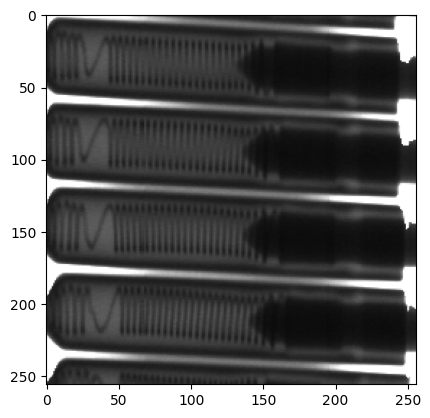

In [15]:
plt.imshow(imagen_bougies, cmap='gray', vmin=0, vmax=255)
plt.show()

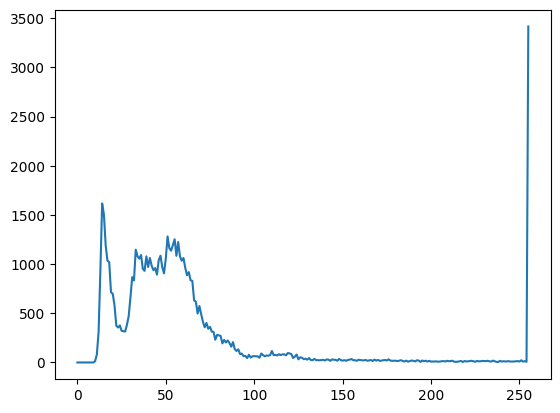

In [16]:
plt.plot(histograma_original)
plt.show()

## Imagen Referencia

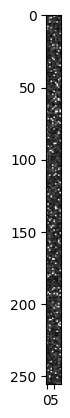

In [17]:
plt.imshow(i_to_match, cmap='gray', vmin=0, vmax=255)
plt.show()

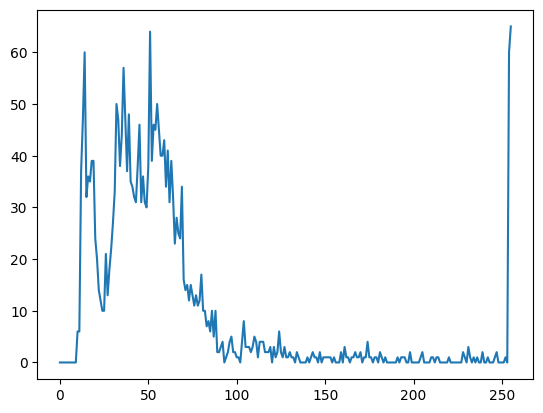

In [18]:
mostrar_histograma(i_to_match)

## Matching

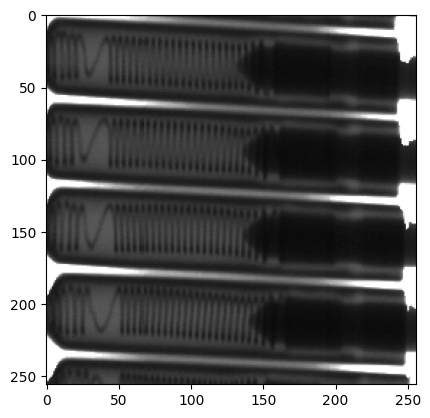

In [19]:
plt.imshow(matched_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [20]:
def show_histogram(image, values=256):
  histogram, bin_edges = np.histogram(image, bins=values, range=(0, values-1))
  fig, ax = plt.subplots()
  ax.set_title("Matching Histogram")
  ax.set_xlabel("grayscale value")
  ax.set_ylabel("pixel count")
  ax.set_xlim([0.0, values-1])

  ax.plot(bin_edges[0:-1], histogram)
  plt.show()

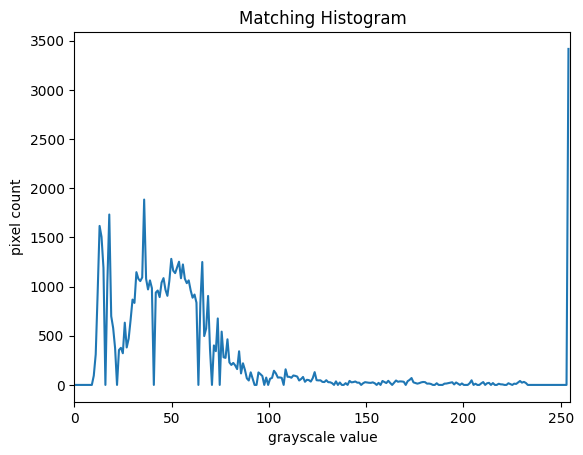

In [21]:
show_histogram(matched_image)

*Comente sus observaciones.*

Utilizando esta técnica, se pudo evidenciar que el histograma resultante tiende a ajustarse al histograma de la imagen de referencia. Se observan los picos característicos del histograma de referencia reflejados en la imagen transformada, lo que indica una mejora en la correspondencia de la distribución de intensidades. En este caso, como se esta trabajando sobre imagenes de escala de grises el cambio no fue muy notable visualmente. Adicionalmente, esta tecnica es utiliza para la correción de color. A continuación, un ejemplo de lo que se puede lograr con imagenes de color.

!["Matching"](images/MATCHING.png)

### *Haga una comparación entre los tipos de transformaciones ¿Qué impactos tiene cada una? ¿Cómo  pueden ser usadas en el ámbito de mejoramiento de la calidad de la imagen?*


**1. Transformación Logarítmica**

**Efecto:**
- Realza los detalles en **regiones oscuras** de la imagen mientras **comprime las regiones brillantes**.
- Mapea valores de intensidad bajos a un **rango más amplio**, aumentando la visibilidad en áreas con poca iluminación.

**Casos de Uso:**
- Útil para imágenes con **alto rango dinámico** (ej. imágenes médicas, satelitales).
- Mejora los **detalles en sombras** sin sobresaturar áreas brillantes.



**2. Ecualización de Histograma**

**Efecto:**
- Redistribuye los valores de intensidad para lograr un **histograma uniforme**.
- Aumenta el contraste global, haciendo que los **detalles ocultos sean más visibles**.

**Casos de Uso:**
- Ideal para imágenes con **bajo contraste** 

**3. Expansión del Histograma**

**Efecto:**
- Expande el rango de intensidad para **ocupar todo el espectro** (0 a 255 en una imagen de 8 bits).
- Mejora el contraste sin alterar la **relación de brillo relativa** entre los píxeles.

**Casos de Uso:**
- Útil para imágenes con **poca variación de intensidad** donde se necesita conservar el brillo original.

**4. Especificación de Histograma**

**Efecto:**
- Modifica el histograma de una imagen para que coincida con **el histograma de una imagen de referencia**.
- Se usa para **corrección de color y estandarización** entre imágenes.

**Casos de Uso:**
- Normalización de **imágenes médicas** para asegurar consistencia en la intensidad.
- Aplicado en **imágenes satelitales** para igualar condiciones de iluminación.